In [1]:
import pandas as pd
import numpy as np
import random
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import seaborn as sns #Visulization
import matplotlib.pyplot as plt #Visulization
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from nltk.probability import FreqDist
from gensim.models import Word2Vec
from gensim import corpora
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


In [2]:
bio = pd.read_csv("biology.csv")
chem = pd.read_csv("chemistry.csv")
math = pd.read_csv("mathematics.csv")
phys = pd.read_csv("physics.csv")
data1 = pd.read_csv("train.csv")
book = pd.read_csv("textbook.csv")

In [3]:
data1 = pd.concat([data1, book])
data1 = data1.sample(frac=1) #перемешаем строки
data1 = data1.reset_index(drop=True)

In [4]:
data1

,label,Column1
0,NaN,NaN
1,биология,Морфология раковинных амеб рода Nebela из сфа...
2,математика,К вопросу о применении генетических методов д...
3,физика,Моделирование звукового поля создаваемого дву...
4,химия,Э йн ш тейний Am Cm Bk Cf Es 5 / 76s-6pc7<s5 ...
...,...,...
334,математика,Предельная теорема для сумм линейно независимы...
335,физика,Методический подход к определению спектра виб...
336,математика,Система обработки данных для высокоточного опр...
337,NaN,NaN


In [5]:
data1.columns = ['label', 'Column1']
data1['Column1'] = data1['Column1'].astype( str )

In [6]:
nltk.download('stopwords')
stop = stopwords.words('russian')
stop.extend(['вак','iii', 'xxx', 'это', 'эти', 'этот', '_', '__', '___', '____', '_____', '_____', '______', '_______', '________'])


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [7]:
bio['Column1'] = bio['Column1'].str.lower()
chem['Column1'] = chem['Column1'].str.lower()
math['Column1'] = math['Column1'].str.lower()
phys['Column1'] = phys['Column1'].str.lower()
data1['Column1'] = data1['Column1'].str.lower()

In [8]:
bio['Column1'] = bio['Column1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
chem['Column1'] = chem['Column1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
math['Column1'] = math['Column1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
phys['Column1'] = phys['Column1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data1['Column1'] = data1['Column1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


In [9]:
bio['original'] = bio['Column1']
chem['original'] = chem['Column1']
math['original'] = math['Column1']
phys['original'] = phys['Column1']
data1['original'] = data1['Column1']

In [10]:
bio['Column1'] = bio['Column1'].replace(r'[^\w\s]',' ',regex=True).replace(r'\s+',' ',regex=True).str.lower()
chem['Column1'] = chem['Column1'].replace(r'[^\w\s]',' ',regex=True).replace(r'\s+',' ',regex=True).str.lower()
math['Column1'] = math['Column1'].replace(r'[^\w\s]',' ',regex=True).replace(r'\s+',' ',regex=True).str.lower()
phys['Column1'] = phys['Column1'].replace(r'[^\w\s]',' ',regex=True).replace(r'\s+',' ',regex=True).str.lower()
data1['Column1'] = data1['Column1'].replace(r'[^\w\s]',' ',regex=True).replace(r'\s+',' ',regex=True).str.lower()

In [11]:
bio['Column1'] = bio['Column1'].replace(r'\W+',' ')
chem['Column1'] = chem['Column1'].replace(r'\W+',' ')
math['Column1'] = math['Column1'].replace(r'\W+',' ')
phys['Column1'] = phys['Column1'].replace(r'\W+',' ')
data1['Column1'] = data1['Column1'].replace(r'\W+',' ')
data1.label = data1.label.str.strip ()

In [12]:
bio['Column1'] = bio.Column1.str.replace(r'\s(\w{1,2})\s', ' ')
chem['Column1'] = chem.Column1.str.replace(r'\s(\w{1,2})\s', ' ')
math['Column1'] =math.Column1.str.replace(r'\b(\w{1,2})\b', ' ')
phys['Column1'] = phys.Column1.str.replace(r'\b(\w{1,2})\b', ' ')
data1['Column1'] = data1.Column1.str.replace(r'\b(\w{1,2})\b', ' ')

In [13]:
bio.dropna()
chem.dropna()
math.dropna()
phys.dropna()
data1.dropna()

,label,Column1,original
1,биология,морфология раковинных амеб рода nebela сфагнов...,морфология раковинных амеб рода nebela сфагнов...
2,математика,вопросу применении генетических методов решени...,вопросу применении генетических методов решени...
3,физика,моделирование звукового поля создаваемого двум...,моделирование звукового поля создаваемого двум...
4,химия,э йн ш тейний am cm bk cf es 5 76s 6pc7 s5 5 f...,э йн ш тейний am cm bk cf es 5 / 76s-6pc7<s5 5...
5,математика,d оптимальное планирование полиномиальной регр...,d-оптимальное планирование полиномиальной регр...
...,...,...,...
333,биология,таксис направленное перемещение организмов отд...,таксис — направленное перемещение организмов о...
334,математика,предельная теорема сумм линейно независимых сл...,предельная теорема сумм линейно независимых сл...
335,физика,методический подход определению спектра вибрац...,методический подход определению спектра вибрац...
336,математика,система обработки данных высокоточного определ...,система обработки данных высокоточного определ...


In [14]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [15]:
stemmer = SnowballStemmer("russian")

In [16]:
bio['Column1'] = bio['Column1'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
chem['Column1'] = chem['Column1'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
math['Column1'] = math['Column1'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
phys['Column1'] = phys['Column1'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
data1['Column1'] = data1['Column1'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

In [17]:
bio['Column1'] = bio['Column1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
chem['Column1'] = chem['Column1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
math['Column1'] = math['Column1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
phys['Column1'] = phys['Column1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data1['Column1'] = data1['Column1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [18]:
bio['Column1'] = bio.Column1.str.replace(r'\b(\S{1,2})\b', ' ', regex=True)
chem['Column1'] = chem.Column1.str.replace(r'\b(\S{1,2})\b', ' ', regex=True)
math['Column1'] = math.Column1.str.replace(r'\b(\S{1,2})\b', ' ', regex=True)
phys['Column1'] = phys.Column1.str.replace(r'\b(\S{1,2})\b', ' ', regex=True)
data1['Column1'] = data1.Column1.str.replace(r'\b(\S{1,2})\b', ' ', regex=True)
bio['Column1'] = bio.Column1.str.replace(r'[0-9]', ' ', regex=True)
chem['Column1'] = chem.Column1.str.replace(r'[0-9]', ' ', regex=True)
math['Column1'] = math.Column1.str.replace(r'[0-9]', ' ', regex=True)
phys['Column1'] = phys.Column1.str.replace(r'[0-9]', ' ', regex=True)
data1['Column1']  = data1.Column1.str.replace(r'[0-9]', ' ', regex=True)

In [19]:
bio['Column1'] = bio['Column1'].replace('   ', ' ')
chem['Column1'] = chem['Column1'].replace('   ', ' ')
math['Column1'] = math['Column1'].replace('   ', ' ')
phys['Column1'] = phys['Column1'].replace('   ', ' ')
data1['Column1'] = data1['Column1'].replace('   ', ' ')

In [20]:
bio['Column1'] = bio['Column1'].replace('   ', ' ')
chem['Column1'] = chem['Column1'].replace('   ', ' ')
math['Column1'] = math['Column1'].replace('   ', ' ')
phys['Column1'] = phys['Column1'].replace('   ', ' ')
data1['Column1'] = data1['Column1'].replace('   ', ' ')

In [21]:
bio['Column1'] = bio['Column1'].replace('  ', ' ')
chem['Column1'] = chem['Column1'].replace('  ', ' ')
math['Column1'] = math['Column1'].replace('  ', ' ')
phys['Column1'] = phys['Column1'].replace('  ', ' ')
data1['Column1'] = data1['Column1'].replace('  ', ' ')

In [22]:
bio['Column1'] = bio['Column1'].replace('  ', ' ')
chem['Column1'] = chem['Column1'].replace('  ', ' ')
math['Column1'] = math['Column1'].replace('  ', ' ')
phys['Column1'] = phys['Column1'].replace('  ', ' ')
data1['Column1'] = data1['Column1'].replace('  ', ' ')

In [23]:
bio['Column1'] = bio['Column1'].replace('  ', ' ')
chem['Column1'] = chem['Column1'].replace('  ', ' ')
math['Column1'] = math['Column1'].replace('  ', ' ')
phys['Column1'] = phys['Column1'].replace('  ', ' ')
data1['Column1'] = data1['Column1'].replace('  ', ' ')

In [24]:
bio['Column1'] = bio['Column1'].replace('  ', ' ')
chem['Column1'] = chem['Column1'].replace('  ', ' ')
math['Column1'] = math['Column1'].replace('  ', ' ')
phys['Column1'] = phys['Column1'].replace('  ', ' ')
data1['Column1'] = data1['Column1'].replace('  ', ' ')

In [25]:
chem.Column1[7]

'особен электрон   локализац влиян макр микроскопическ свойств молекул гидратирова макромолекулярн сист'

In [26]:
bio['number_of_words'] = bio.Column1.apply(lambda x: len(x.split()))
chem['number_of_words'] = chem.Column1.apply(lambda x: len(x.split()))
math['number_of_words'] = math.Column1.apply(lambda x: len(x.split()))
phys['number_of_words'] = phys.Column1.apply(lambda x: len(x.split()))
data1['number_of_words'] = data1.Column1.apply(lambda x: len(x.split()))

In [27]:
bio = bio[bio.number_of_words > 4]
chem = chem[chem.number_of_words > 4]
math = math[math.number_of_words > 4]
phys = phys[phys.number_of_words > 4]
data1 = data1[data1.number_of_words > 5]

In [28]:
bio.insert (loc= 0 , column='label', value= "биология")
chem.insert (loc= 0 , column='label', value= "химия")
math.insert (loc= 0 , column='label', value= "математика")
phys.insert (loc= 0 , column='label', value= "физика")

In [29]:
data = pd.concat([bio, chem, math, phys])
data = data.sample(frac=1) #перемешаем строки
data = data.reset_index(drop=True)

In [30]:
data

,label,Column1,original,number_of_words
0,математика,асимптотическ свойств медлен функц субгармонич...,асимптотические свойства медленно меняющихся ф...,8
1,математика,метод неотрицательн определен функц метрическ ...,метод неотрицательно определенных функций метр...,8
2,химия,квантов химическ моделирован адсорбц каталитич...,квантово-химическое моделирование адсорбции ка...,16
3,физика,адрон процесс эффект электрослаб взаимодейств ...,адронные процессы эффекты электрослабых взаимо...,8
4,математика,алгоритм вычислен многомерн степен сумм корн с...,алгоритмы вычисления многомерных степенных сум...,9
...,...,...,...,...
63978,математика,автомодельн решен интегральн уравнен теор конв...,автомодельных решениях интегральных уравнений ...,9
63979,биология,зменен биохимическ показател ротов жидкост раз...,�зменения биохимических показателей ротовой жи...,14
63980,химия,синтез нов протатран трис гидроксиэт амин ди...,синтез новых протатранов трис(2-гидроксиэтил)а...,13
63981,биология,сследован механизм транспорт протон бактериоро...,�сследование механизма транспорта протона бакт...,11


In [31]:
data1

,label,Column1,original,number_of_words
1,биология,морфолог раковин амеб род nebela сфагнов болот...,морфология раковинных амеб рода nebela сфагнов...,60
2,математика,вопрос применен генетическ метод решен задач п...,вопросу применении генетических методов решени...,35
3,физика,моделирован звуков пол создава двумерн преобра...,моделирование звукового поля создаваемого двум...,8
4,химия,тейн s pc s ...,э йн ш тейний am cm bk cf es 5 / 76s-6pc7<s5 5...,2632
5,математика,оптимальн планирован полиномиальн регресс вы...,d-оптимальное планирование полиномиальной регр...,82
...,...,...,...,...
333,биология,таксис направлен перемещен организм отдельн кл...,таксис — направленное перемещение организмов о...,406
334,математика,предельн теорем сумм линейн независим случайн ...,предельная теорема сумм линейно независимых сл...,26
335,физика,методическ подход определен спектр вибрац инже...,методический подход определению спектра вибрац...,174
336,математика,систем обработк дан высокоточн определен углов...,система обработки данных высокоточного определ...,71


In [32]:
print("Анализ данных названий диссертаций:")
max_len = data['number_of_words'].max()
print("максимальная длина строки, слов:", max_len)
mixValues = data['number_of_words'].min()
print("миниимальная длина строки, слов:", mixValues)
meanValues = data['number_of_words'].mean()
print("средняя длина строки, слов:", meanValues)
sumValues = data['number_of_words'].sum()
print("всего слов:", sumValues)
print('Всего строк:', len(data))

Анализ данных названий диссертаций:
максимальная длина строки, слов: 32
миниимальная длина строки, слов: 5
средняя длина строки, слов: 9.160386352624917
всего слов: 586109
Всего строк: 63983


In [33]:
print("Анализ данных обучающих текстов:")
max_len = data1['number_of_words'].max()
print("максимальная длина строки, слов:", max_len)
mixValues = data1['number_of_words'].min()
print("миниимальная длина строки, слов:", mixValues)
meanValues = data1['number_of_words'].mean()
print("средняя длина строки, слов:", meanValues)
sumValues = data1['number_of_words'].sum()
print("всего слов:", sumValues)
print('Всего строк:', len(data1))
print('Всего строк в двух датафреймах:', len(data1)+len(data))

Анализ данных обучающих текстов:
максимальная длина строки, слов: 2666
миниимальная длина строки, слов: 7
средняя длина строки, слов: 411.9778481012658
всего слов: 130185
Всего строк: 316
Всего строк в двух датафреймах: 64299


<Axes: title={'center': 'Распределение по длине названий диссертаций'}, ylabel='Density'>

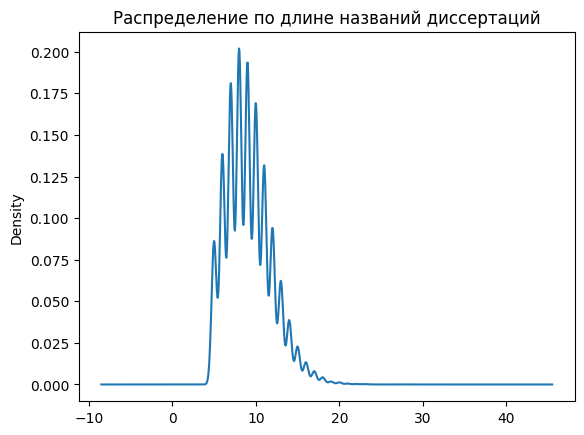

In [34]:
data['number_of_words'].plot(kind='kde', title='Распределение по длине названий диссертаций')

<Axes: title={'center': 'Распределение по длине обучающего текста'}, ylabel='Density'>

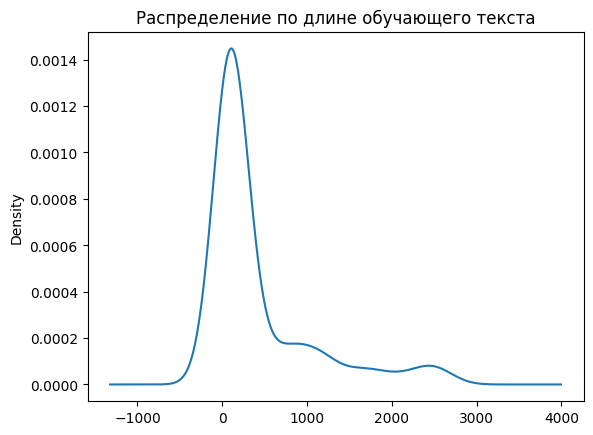

In [35]:
data1['number_of_words'].plot(kind='kde', title='Распределение по длине обучающего текста')

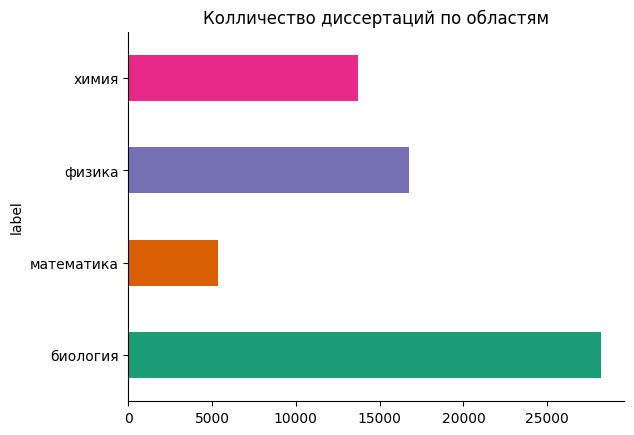

In [36]:
data.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Колличество диссертаций по областям')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [37]:
train, test = train_test_split(data, test_size=0.2)

In [38]:
train = pd.concat([train, data1])

In [39]:
train = train.sample(frac=1)

In [40]:
train['label'].value_counts()

label
биология      22663
физика        13459
химия         11010
математика     4370
Name: count, dtype: int64

In [41]:
!pip install gensim


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
rows = len(train.axes[0])
print(rows)

51502


In [43]:
sent_length= 600

In [44]:
for i in range(1, rows):
  a=len(train['Column1'].loc[train.index[i]])//sent_length
  if a==0:
    continue
  else:
    for j in range(a):
      train['Column1'].loc[train.index[i]]=train['Column1'].loc[train.index[i]][:sent_length*j-1]+" 7777 "+ train['Column1'].loc[train.index[i]][sent_length*j:]



C:\Users\apex_\AppData\Local\Temp\ipykernel_13144\3996188144.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train['Column1'].loc[train.index[i]]=train['Column1'].loc[train.index[i]][:sent_length*j-1]+" 7777 "+ train['Column1'].loc[train

In [45]:
# Split text into a list
train['Column1'] = train['Column1'].str.split(' 7777 ')
# Convert list into multiple rows
train = train.explode('Column1')
train = train.reset_index(drop=True)

In [46]:
train['text_len_2'] = [len(text.split()) for text in train.Column1]

In [47]:
max_len_2 = train['text_len_2'].max()
print("максимальная длина строки, слов:", max_len_2)
mixValues = train['text_len_2'].min()
print("миниимальная длина строки, слов:", mixValues)
meanValues = train['text_len_2'].mean()
print("средняя длина строки, слов:", meanValues)
sumValues = train['text_len_2'].sum()
print("всего слов:", sumValues)
print('Всего строк в train:', len(train))
print('Всего строк в test:', len(test))
print('Всего строк:', len(test)+len(train))

максимальная длина строки, слов: 2666
миниимальная длина строки, слов: 5
средняя длина строки, слов: 11.99183555298205
всего слов: 621297
Всего строк в train: 51810
Всего строк в test: 12797
Всего строк: 64607


In [48]:
train['Column1'] = train.Column1.str.replace(r'\b(\S{1,2})\b', ' ', regex=True)

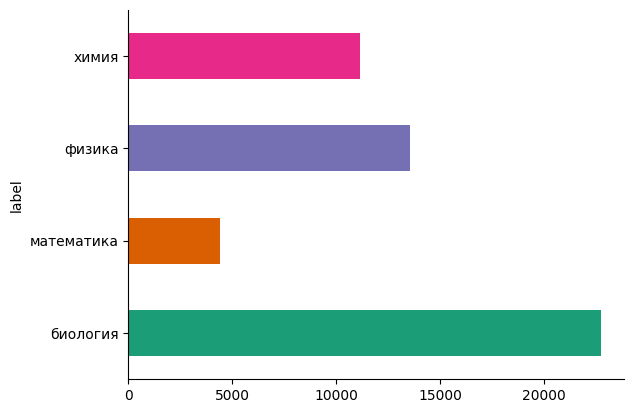

In [49]:
train.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [50]:
train['label'] = train['label'].replace({"химия": 0, "физика": 1, "математика": 2, "биология":3})
test['label'] = test['label'].replace({"химия": 0, "физика": 1, "математика": 2, "биология":3})

C:\Users\apex_\AppData\Local\Temp\ipykernel_13144\1143508244.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['label'] = train['label'].replace({"химия": 0, "физика": 1, "математика": 2, "биология":3})
C:\Users\apex_\AppData\Local\Temp\ipykernel_13144\1143508244.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['label'] = test['label'].replace({"химия": 0, "физика": 1, "математика": 2, "биология":3})


In [51]:
train_y = np.array(train['label'])
train_X= np.array(train['Column1'])
test_y = np.array(test['label'])
test_X= np.array(test['Column1'])
test_X_orig = np.array(test['original'])

In [52]:
sentences = [sentence.split() for sentence in train['Column1']]

In [53]:
tokens = []
for row in train['Column1']:
    tokens.extend(row.split())
for row in test['Column1']:
    tokens.extend(row.split())

In [54]:
fdist = FreqDist(tokens)
print("Наиболее часто встречающиеся токены (слова):")
print(fdist.most_common(100))

Наиболее часто встречающиеся токены (слова):
[('свойств', 7002), ('основ', 4855), ('исследован', 4852), ('метод', 4601), ('структур', 4581), ('систем', 4381), ('синтез', 4013), ('процесс', 3949), ('влиян', 3759), ('особен', 3412), ('химическ', 2748), ('услов', 2721), ('состоян', 2654), ('анализ', 2617), ('характеристик', 2518), ('электрон', 2501), ('соединен', 2442), ('активн', 2423), ('реакц', 2381), ('взаимодейств', 2347), ('металл', 2326), ('сист', 2205), ('пол', 2136), ('некотор', 2131), ('сред', 2077), ('биологическ', 1972), ('функц', 1957), ('разработк', 1957), ('задач', 1914), ('уравнен', 1869), ('комплекс', 1840), ('функциональн', 1822), ('механизм', 1805), ('ион', 1779), ('нов', 1775), ('молекулярн', 1700), ('веществ', 1695), ('магнитн', 1691), ('применен', 1687), ('получен', 1672), ('оценк', 1638), ('динамик', 1613), ('физик', 1602), ('структурн', 1590), ('раствор', 1560), ('формирован', 1542), ('област', 1532), ('использован', 1509), ('различн', 1487), ('производн', 1485), (

In [55]:
print('Количество уникальных токенов:', len(fdist))

Количество уникальных токенов: 56813


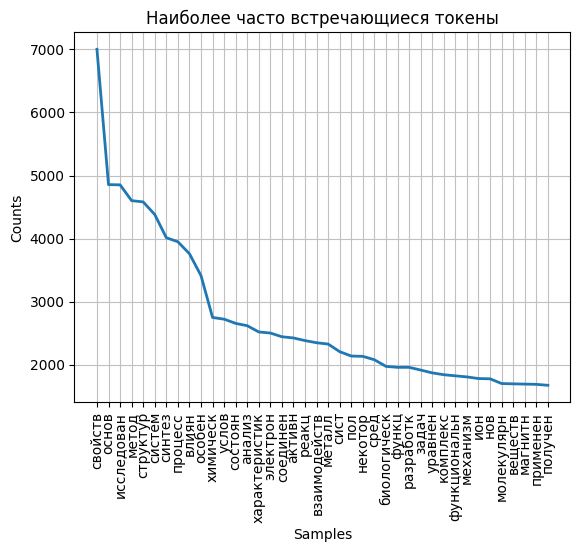

<Axes: title={'center': 'Наиболее часто встречающиеся токены'}, xlabel='Samples', ylabel='Counts'>

In [56]:
fdist.plot(40, title="Наиболее часто встречающиеся токены", cumulative=False, percents=False)

In [57]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (51810,)
Test shape :  (12797,)


(-1.0999999998972931,
 1.0999999999951091,
 -1.0999999996652727,
 1.0999999999707768)

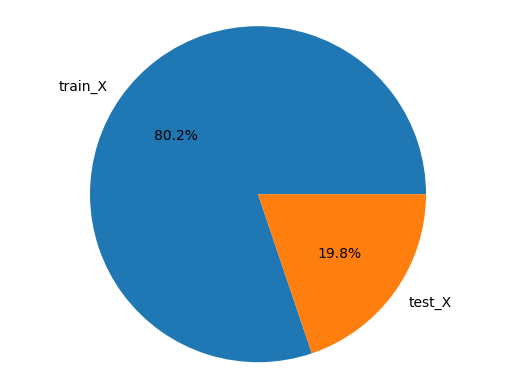

In [58]:
vals = [len(train_X), len(test_X)]
labels = ["train_X", "test_X"]
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%')
ax.axis("equal")

In [59]:
print("количество предложений:", len(sentences))

количество предложений: 51810


In [60]:
# Average String lengths in list
# using list comprehension + sum() + len()
temp = [len(ele) for ele in sentences]
res = 0 if len(temp) == 0 else (float(sum(temp)) / len(temp))

# printing result
print("Total q-ty of token : ", sum(temp))
print("The Average length of String in list is : " + str(res))

Total q-ty of token :  616687
The Average length of String in list is : 11.902856591391624


In [61]:
%%time
w2v_model = Word2Vec(sentences, window=10, min_count=1, workers=4, epochs=30, sg=0, negative=5)
print(w2v_model)

Word2Vec<vocab=52691, vector_size=100, alpha=0.025>
CPU times: total: 27.7 s
Wall time: 14 s


In [62]:
w2v_model.build_vocab(sentences)
print(w2v_model)

Word2Vec<vocab=52691, vector_size=100, alpha=0.025>


In [63]:
%%time
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

CPU times: total: 26 s
Wall time: 13.3 s


(17905107, 18500610)

In [64]:
w2v_model.save('Word2VecModel')

In [65]:
print("Общее количество слов в обученном словаре:", len(w2v_model.wv.index_to_key))

Общее количество слов в обученном словаре: 52691


In [66]:
print('Косинусная близость слов к слову "клетка":')
w2v_model.wv.most_similar('клетк')

Косинусная близость слов к слову "клетка":


[('клеток', 0.6184746623039246),
 ('цитоплазм', 0.5064771771430969),
 ('оформлен', 0.4831921458244324),
 ('ткан', 0.4828977584838867),
 ('одноклеточн', 0.4687115550041199),
 ('пластид', 0.46730220317840576),
 ('голоцен', 0.43709293007850647),
 ('свойствен', 0.4296567738056183),
 ('медуз', 0.4252815842628479),
 ('прокариот', 0.4245578944683075)]

In [67]:
w2v_model.wv.index_to_key

['свойств',
 'основ',
 'исследован',
 'структур',
 'метод',
 'систем',
 'синтез',
 'процесс',
 'влиян',
 'особен',
 'химическ',
 'состоян',
 'услов',
 'электрон',
 'анализ',
 'характеристик',
 'соединен',
 'реакц',
 'металл',
 'взаимодейств',
 'активн',
 'пол',
 'сист',
 'некотор',
 'сред',
 'функц',
 'уравнен',
 'биологическ',
 'разработк',
 'задач',
 'комплекс',
 'веществ',
 'ион',
 'функциональн',
 'механизм',
 'нов',
 'молекулярн',
 'применен',
 'магнитн',
 'получен',
 'раствор',
 'оценк',
 'динамик',
 'физик',
 'област',
 'структурн',
 'кислот',
 'различн',
 'действ',
 'производн',
 'формирован',
 'использован',
 'теор',
 'котор',
 'растен',
 'вид',
 'моделирован',
 'рол',
 'сследован',
 'излучен',
 'элемент',
 'пример',
 'ген',
 'эффект',
 'модел',
 'воздейств',
 'экологическ',
 'вод',
 'развит',
 'человек',
 'материал',
 'решен',
 'энерг',
 'групп',
 'связ',
 'определен',
 'тип',
 'белк',
 'организм',
 'генетическ',
 'поверхн',
 'изменен',
 'фактор',
 'почв',
 'экспериментальн',

In [68]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_w2v = ([vectorize(sentence) for sentence in train_X])
X_test_w2v = ([vectorize(sentence) for sentence in test_X])

In [69]:
#model_ru = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [70]:
#def vectorize_2(sentence):
#    words = sentence.split()
#    words_vecs = [model_ru[word] for word in words if word in model_ru]
#    if len(words_vecs) == 0:
#        return np.zeros(100)
#    words_vecs = np.array(words_vecs)
#    return words_vecs.mean(axis=0)

#X_train_ru = ([vectorize_2(sentence) for sentence in train_X])
#X_test_ru = ([vectorize_2(sentence) for sentence in test_X])
#len(X_train_ru)

In [71]:
vectorizer_3 = HashingVectorizer(ngram_range=(1, 2), n_features=8388608)
X_train_hs = vectorizer_3.fit_transform(train_X)
X_test_hs = vectorizer_3.transform(test_X)
print(X_train_hs.shape)


(51810, 8388608)


In [72]:
vectorizer_3.get_params()

{'alternate_sign': True,
 'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'n_features': 8388608,
 'ngram_range': (1, 2),
 'norm': 'l2',
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None}

In [73]:
vectorizer_4 = CountVectorizer(ngram_range=(1,2))
#clf = TfidfVectorizer()
X_train_cv =  vectorizer_4.fit_transform(train_X)
X_test_cv = vectorizer_4.transform(test_X)
print(X_train_cv.shape)

(51810, 376370)


In [74]:
vectorizer_4.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 2),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [75]:
tf_transformer = TfidfTransformer(use_idf=True, sublinear_tf=True).fit(X_train_cv)
X_train_tf = tf_transformer.fit_transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)
print(X_train_tf.shape)

(51810, 376370)


In [76]:
vectorizer_4.get_feature_names_out()[:50]

array(['aabb', 'aabb aabb', 'aabb аав', 'aabb аавв', 'aad',
       'aad иммортализова', 'aaptos', 'abam', 'abc', 'abc abc',
       'abc рецессивн', 'abc собствен', 'abc такж', 'abca',
       'abca атеросклероз', 'abcc', 'abcc транспортер', 'abcg',
       'abcg аполипопротеин', 'abcl', 'abcl bcl', 'abcosc',
       'abcosc absinc', 'abcosc acosc', 'abcosc абсолютн', 'abcosc найд',
       'abd', 'abd drosophila', 'abdominal', 'abdominal drosophila',
       'abdr', 'abies', 'abies hill', 'abies holophylla', 'abies karst',
       'abies mill', 'abies nephrolepis', 'abies pungens',
       'abies sibirica', 'abies процесс', 'abietinus',
       'abietinus tristis', 'abietoideae', 'abietoideae rich', 'abl',
       'abl развит', 'abo', 'abo тверд', 'abortus', 'abortus francisella'],
      dtype=object)

In [77]:
# Создание экземпляра ADASYN
adasyn = ADASYN()
smote = SMOTE()
rus = RandomUnderSampler()
ros = RandomOverSampler()

# Применение ADASYN к данным
X_train_os, y_train_os = smote.fit_resample(X_train_tf, train_y);

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

In [79]:
logreg = LogisticRegression(C= 3.36, class_weight= 'balanced', solver='liblinear',
    random_state=42, max_iter=100
)

In [80]:
logreg.fit(X_train_hs, train_y)

LogisticRegression(C=3.36, class_weight='balanced', random_state=42,
                   solver='liblinear')

In [81]:
log_pred_6 = logreg.predict(X_test_hs)

In [82]:
print("метрики для LogisticRegression(C= 3.36, class_weight= balanced, solver=liblinear, max_iter=100 ), HashingVectorizer(ngram_range=(1, 2), n_features=8388608)")
print('F1 weighted:', f1_score(test_y, log_pred_6, average='weighted'))
print('F1 macro:',f1_score(test_y, log_pred_6, average='macro'))
print('accuracy:', accuracy_score(test_y, log_pred_6))

метрики для LogisticRegression(C= 3.36, class_weight= balanced, solver=liblinear, max_iter=100 ), HashingVectorizer(ngram_range=(1, 2), n_features=8388608)
F1 weighted: 0.9292386182397485
F1 macro: 0.9216819329927921
accuracy: 0.929280300070329


In [83]:
logreg.fit(X_train_w2v, train_y)

LogisticRegression(C=3.36, class_weight='balanced', random_state=42,
                   solver='liblinear')

In [84]:
log_pred_3 = logreg.predict(X_test_w2v)

In [85]:
print(f1_score(test_y, log_pred_3, average='weighted'))
print(f1_score(test_y, log_pred_3, average='macro'))
print(accuracy_score(test_y, log_pred_3))

0.9118907495516737
0.9015918388500108
0.9116980542314606


In [86]:
print("метрики для LogisticRegression(C= 3.36, class_weight= balanced, solver=liblinear, max_iter=100 ), Word2Vec(sentences, window=10, min_count=1, workers=4, epochs=30, sg=0, negative=5)")
print('F1 weighted:', f1_score(test_y, log_pred_3, average='weighted'))
print('F1 macro:',f1_score(test_y, log_pred_3, average='macro'))
print('accuracy:', accuracy_score(test_y, log_pred_3))

метрики для LogisticRegression(C= 3.36, class_weight= balanced, solver=liblinear, max_iter=100 ), Word2Vec(sentences, window=10, min_count=1, workers=4, epochs=30, sg=0, negative=5)
F1 weighted: 0.9118907495516737
F1 macro: 0.9015918388500108
accuracy: 0.9116980542314606


In [87]:
#logreg.fit(X_train_ru, train_y)

In [88]:
#log_pred_4 = logreg.predict(X_test_ru)

In [89]:
#print("метрики для LogisticRegression(C= 3.36, class_weight= balanced, solver=liblinear, max_iter=100 ), Word2Vec model -- ruscorpora_upos_cbow_300_20_2019")
#print('F1 weighted:', f1_score(test_y, log_pred_4, average='weighted'))
#print('F1 macro:',f1_score(test_y, log_pred_4, average='macro'))
#print('accuracy:', accuracy_score(test_y, log_pred_4))

In [90]:
logreg.fit(X_train_os, y_train_os)

LogisticRegression(C=3.36, class_weight='balanced', random_state=42,
                   solver='liblinear')

In [91]:
log_pred_1 = logreg.predict(X_test_tf)

In [92]:
print("метрики для LogisticRegression(C= 3.36, class_weight= balanced, solver=liblinear, max_iter=100 ), TfidfTransformer(use_idf=True, sublinear_tf=True)")
print('F1 weighted:', f1_score(test_y, log_pred_1, average='weighted'))
print('F1 macro:',f1_score(test_y, log_pred_1, average='macro'))
print('accuracy:', accuracy_score(test_y, log_pred_1))

метрики для LogisticRegression(C= 3.36, class_weight= balanced, solver=liblinear, max_iter=100 ), TfidfTransformer(use_idf=True, sublinear_tf=True)
F1 weighted: 0.9337140338146621
F1 macro: 0.9269784087916206
accuracy: 0.9335781823864968


In [93]:
print('Classification Report for Logistic regresion:\n',classification_report(test_y, log_pred_1))

Classification Report for Logistic regresion:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      2799
           1       0.91      0.92      0.91      3352
           2       0.92      0.95      0.94      1048
           3       0.97      0.96      0.97      5598

    accuracy                           0.93     12797
   macro avg       0.92      0.93      0.93     12797
weighted avg       0.93      0.93      0.93     12797



In [94]:
logreg.fit(X_train_cv, train_y)

LogisticRegression(C=3.36, class_weight='balanced', random_state=42,
                   solver='liblinear')

In [95]:
log_pred_5 = logreg.predict(X_test_cv)

In [96]:
print("метрики для LogisticRegression(C= 3.36, class_weight= balanced, solver=liblinear, max_iter=100 ), CountVectorizer(ngram_range=(1,2)")
print('F1 weighted:', f1_score(test_y, log_pred_5, average='weighted'))
print('F1 macro:',f1_score(test_y, log_pred_5, average='macro'))
print('accuracy:', accuracy_score(test_y, log_pred_5))

метрики для LogisticRegression(C= 3.36, class_weight= balanced, solver=liblinear, max_iter=100 ), CountVectorizer(ngram_range=(1,2)
F1 weighted: 0.9376550526497242
F1 macro: 0.9310242834007947
accuracy: 0.9377197780729859


In [97]:
print('Classification Report for Logistic regresion:\n',classification_report(test_y, log_pred_5))

Classification Report for Logistic regresion:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      2799
           1       0.91      0.93      0.92      3352
           2       0.94      0.94      0.94      1048
           3       0.97      0.97      0.97      5598

    accuracy                           0.94     12797
   macro avg       0.93      0.93      0.93     12797
weighted avg       0.94      0.94      0.94     12797



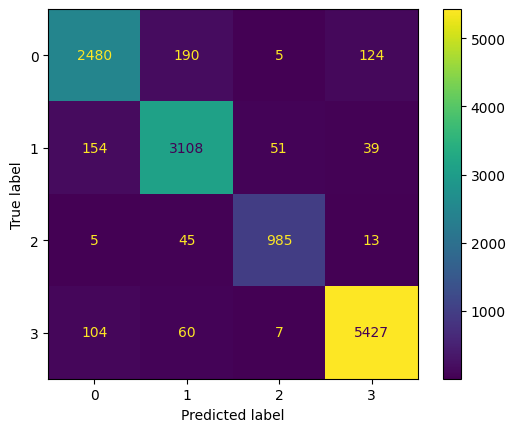

In [98]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(
    test_y, log_pred_5)

In [99]:
%%time
from sklearn.linear_model import SGDClassifier
clf7 = SGDClassifier(max_iter=5000, penalty='l2', loss='hinge')
clf7.fit(X_train_cv, train_y)
SGD = clf7.predict(X_test_cv)
print("метрики для SGDClassifier(max_iter=5000, penalty='l2', loss='hinge') CountVectorizer(ngram_range=(1,2)")
print('F1 weighted:', f1_score(test_y, SGD, average='weighted'))
print('F1 macro:',f1_score(test_y, SGD, average='macro'))
print('accuracy:', accuracy_score(test_y, SGD))


метрики для SGDClassifier(max_iter=5000, penalty='l2', loss='hinge') CountVectorizer(ngram_range=(1,2)
F1 weighted: 0.9388856237903005
F1 macro: 0.9322039219769065
accuracy: 0.9390482144252559
CPU times: total: 688 ms
Wall time: 841 ms


In [100]:
print('Classification Report for SGDClassifier:\n',classification_report(test_y, SGD))

Classification Report for SGDClassifier:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90      2799
           1       0.91      0.93      0.92      3352
           2       0.95      0.93      0.94      1048
           3       0.97      0.97      0.97      5598

    accuracy                           0.94     12797
   macro avg       0.93      0.93      0.93     12797
weighted avg       0.94      0.94      0.94     12797



In [101]:
%%time
from sklearn.calibration import CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(clf7, cv=10, method='sigmoid')
calibrated_clf.fit(X_train_cv, train_y)
log_pred_7 = calibrated_clf.predict(X_test_cv)
print("метрики для LogisticRegression(C= 3.36, class_weight= balanced, solver=liblinear, max_iter=100 ), CalibratedClassifierCV(logreg, cv=5, method=sigmoid), CountVectorizer(ngram_range=(1,2)")
print('F1 weighted:', f1_score(test_y, log_pred_7, average='weighted'))
print('F1 macro:',f1_score(test_y, log_pred_7, average='macro'))
print('accuracy:', accuracy_score(test_y, log_pred_7))


метрики для LogisticRegression(C= 3.36, class_weight= balanced, solver=liblinear, max_iter=100 ), CalibratedClassifierCV(logreg, cv=5, method=sigmoid), CountVectorizer(ngram_range=(1,2)
F1 weighted: 0.9399149840548995
F1 macro: 0.9329294416534326
accuracy: 0.9400640775181683
CPU times: total: 6.73 s
Wall time: 8.18 s


In [102]:
from sklearn import metrics

In [103]:
logreg.fit(X_train_tf, train_y)

LogisticRegression(C=3.36, class_weight='balanced', random_state=42,
                   solver='liblinear')

In [104]:
log_pred_2 = logreg.predict(X_test_tf)

In [105]:
print(f1_score(test_y, log_pred_2, average='weighted'))
print(f1_score(test_y, log_pred_2, average='macro'))
print(accuracy_score(test_y, log_pred_2))

0.9332491906719933
0.9266699401264914
0.9331874658122997


In [106]:
#({0: "химия", 1: "физика", 2: "математика", 3: "биология"})

In [107]:
print('Classification Report for Logistic regresion:\n',classification_report(test_y, log_pred_2))

Classification Report for Logistic regresion:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      2799
           1       0.90      0.92      0.91      3352
           2       0.93      0.94      0.94      1048
           3       0.97      0.96      0.97      5598

    accuracy                           0.93     12797
   macro avg       0.93      0.93      0.93     12797
weighted avg       0.93      0.93      0.93     12797



In [108]:
from sklearn.utils.class_weight import compute_class_weight

# Получение весов классов
class_weights = compute_class_weight('balanced', classes=np.unique([0,1,2,3]), y=train_y)

# Создание модели с взвешиванием классов
SGD_model = SGDClassifier(class_weight=dict(enumerate(class_weights)), max_iter=5000)

In [109]:
SGD_model.fit(X_train_cv, train_y)
SGD2 = SGD_model.predict(X_test_cv)
print("метрики для SGDClassifier(max_iter=5000, penalty='l2', loss='hinge'), compute_class_weight, CountVectorizer(ngram_range=(1,2)")
print('F1 weighted:', f1_score(test_y, SGD2, average='weighted'))
print('F1 macro:',f1_score(test_y, SGD2, average='macro'))
print('accuracy:', accuracy_score(test_y, SGD2))

метрики для SGDClassifier(max_iter=5000, penalty='l2', loss='hinge'), compute_class_weight, CountVectorizer(ngram_range=(1,2)
F1 weighted: 0.9391867654551798
F1 macro: 0.9320200209209664
accuracy: 0.9392826443697742


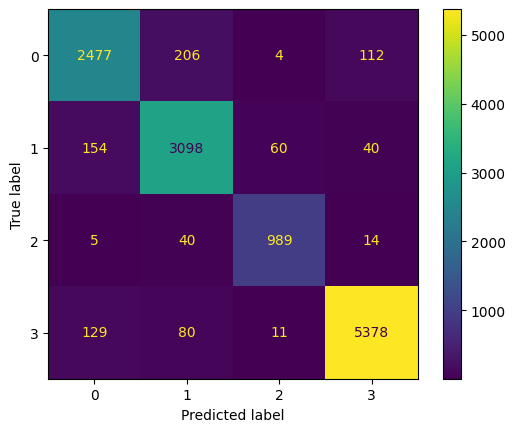

In [110]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(
    test_y, log_pred_2)

In [111]:
ypred = calibrated_clf.predict_proba(X_test_cv)

In [112]:
ypred_list = ypred.tolist()

In [113]:
pred = pd.DataFrame(ypred_list, columns=['химия', 'физика', 'математика', 'биология'])

In [114]:
test = pd.DataFrame({'test_text_original': test_X_orig})
label = pd.DataFrame({'test_label':test_y})
test = pd.concat([test, label, pred], sort=False, axis=1)
test['test_label'] = test['test_label'].replace({0: "химия", 1: "физика", 2: "математика", 3: "биология"})
test

,test_text_original,test_label,химия,физика,математика,биология
0,органо-неорганические композиции основе ацилпи...,химия,0.974021,0.024171,0.001318,0.000490
1,кинетические явления плазме тлеющего разряда м...,физика,0.007069,0.989846,0.000719,0.002366
2,эколого-географический анализ заболеваемости з...,биология,0.005288,0.001278,0.006068,0.987367
3,исследование статистических свойств хаотически...,физика,0.004485,0.934820,0.060249,0.000445
4,точные оценки погрешности оптимальных квадрату...,математика,0.002763,0.001042,0.992493,0.003702
...,...,...,...,...,...,...
12792,гетерогенные полупроводниковые суспендированны...,химия,0.735199,0.261944,0.000715,0.002142
12793,особенности структуры фазового состава ряда же...,физика,0.179702,0.786804,0.008108,0.025386
12794,кулики (charadrii) приамурья видовой состав ми...,биология,0.028855,0.006768,0.003267,0.961110
12795,функционально замещенные карбоцианины основа с...,химия,0.968619,0.003792,0.004307,0.023282


In [115]:
# Создание файла.
#from matplotlib.backends.backend_pdf import PdfPages
#pdf = PdfPages("Figures.pdf")

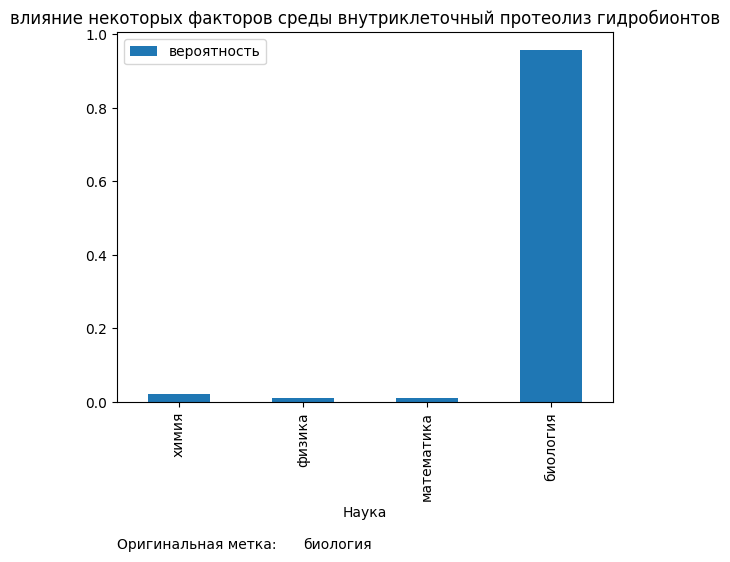

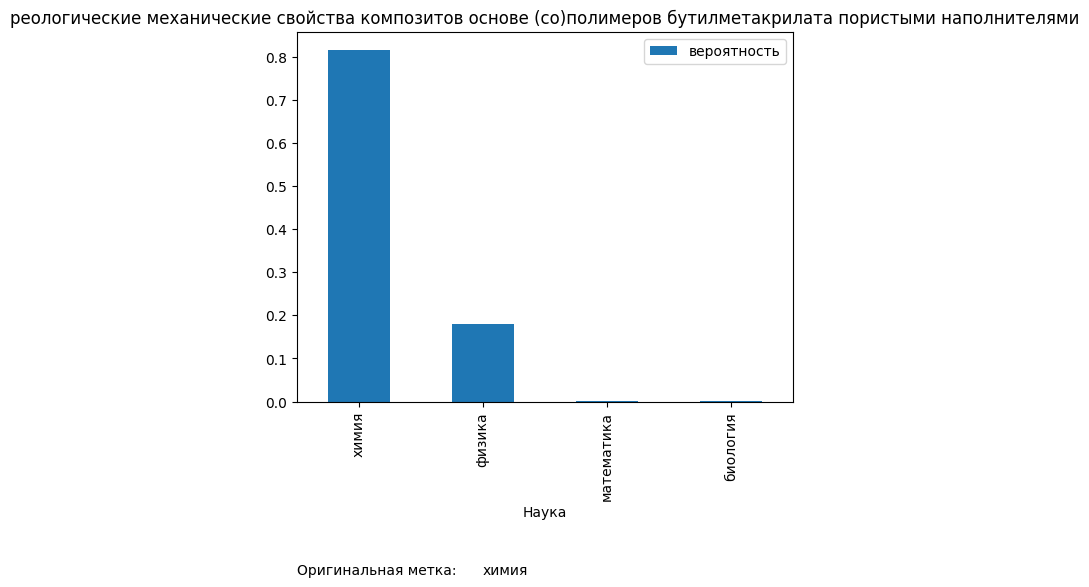

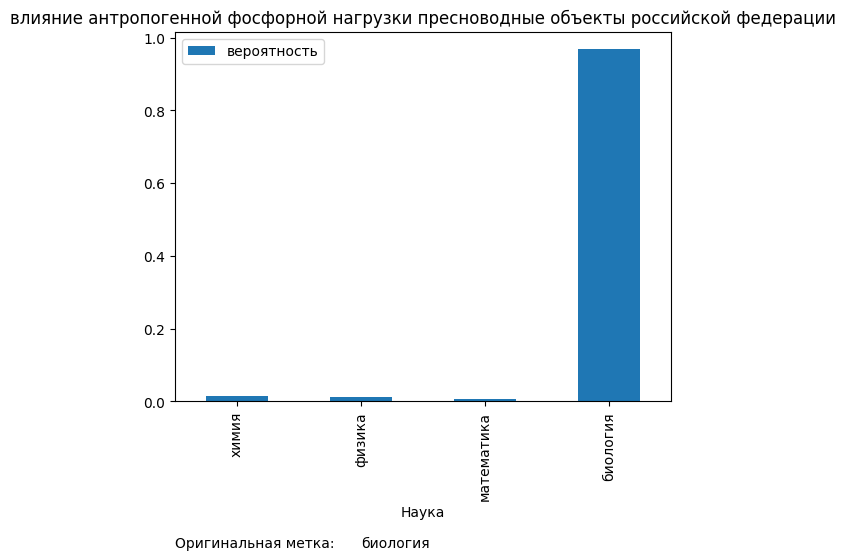

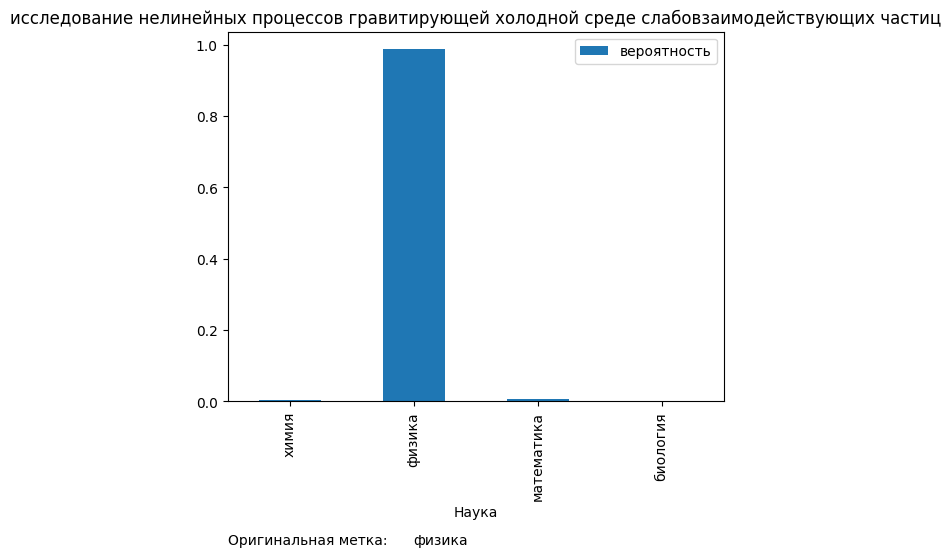

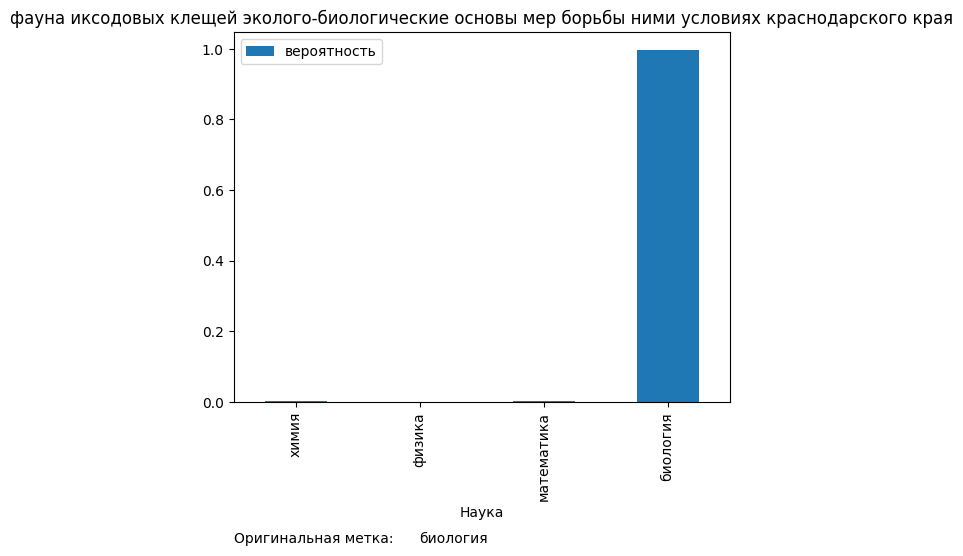

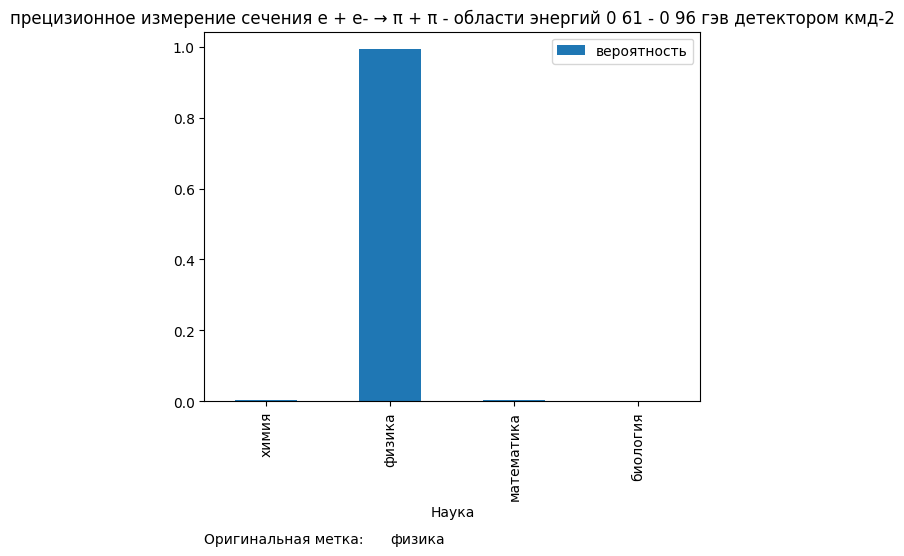

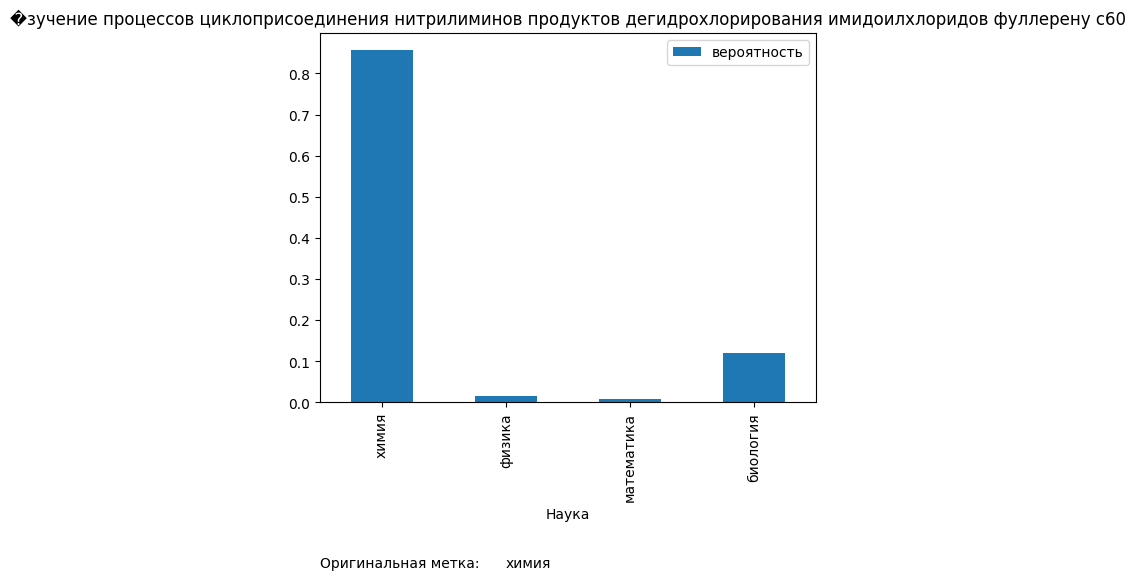

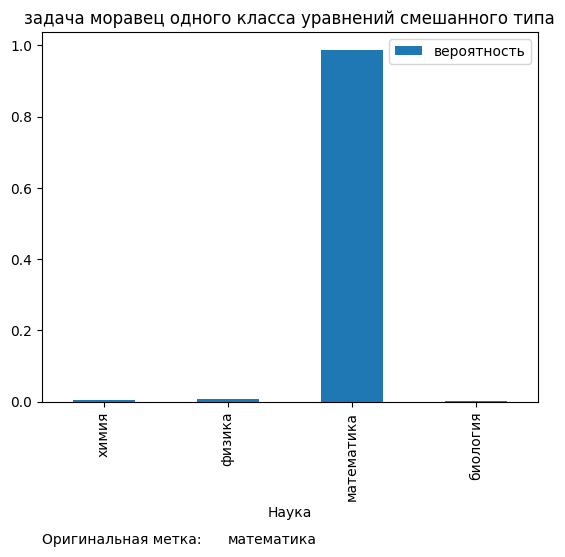

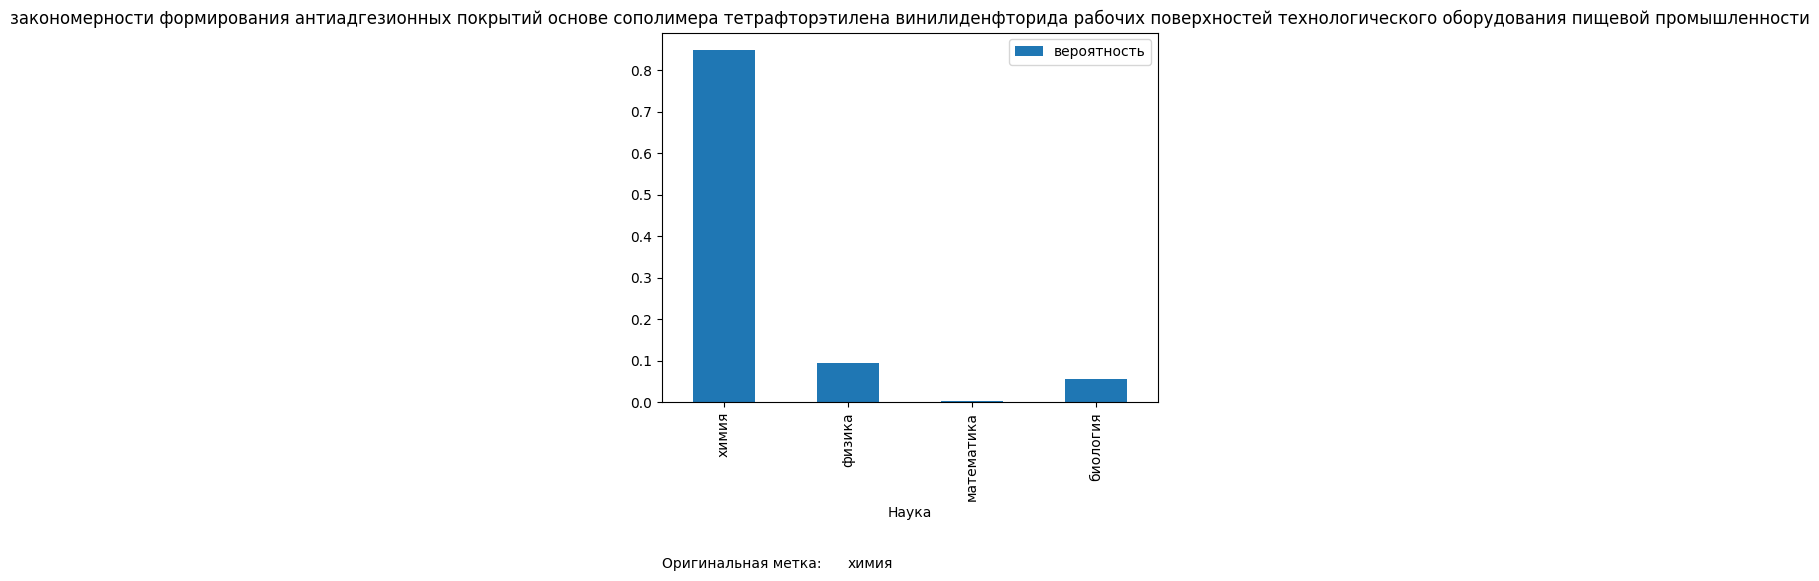

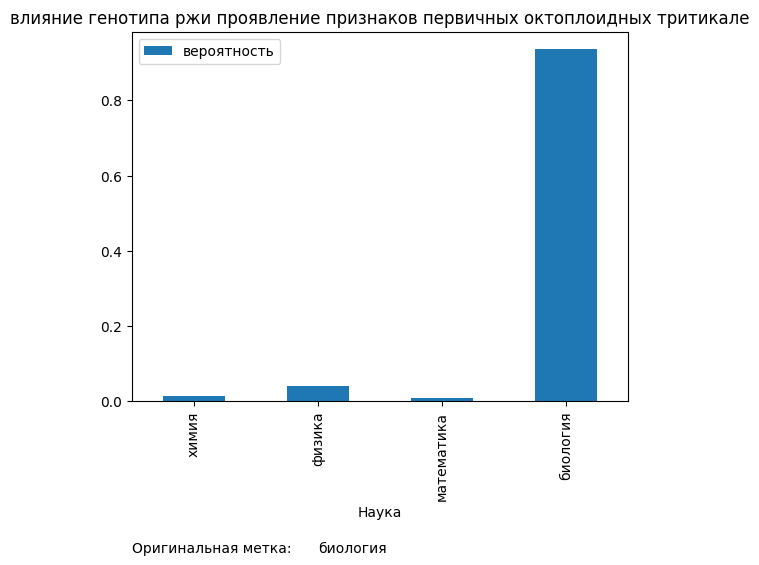

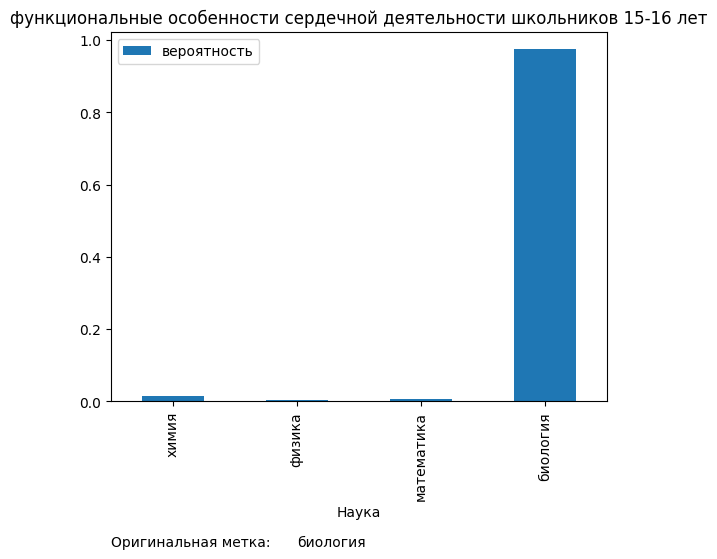

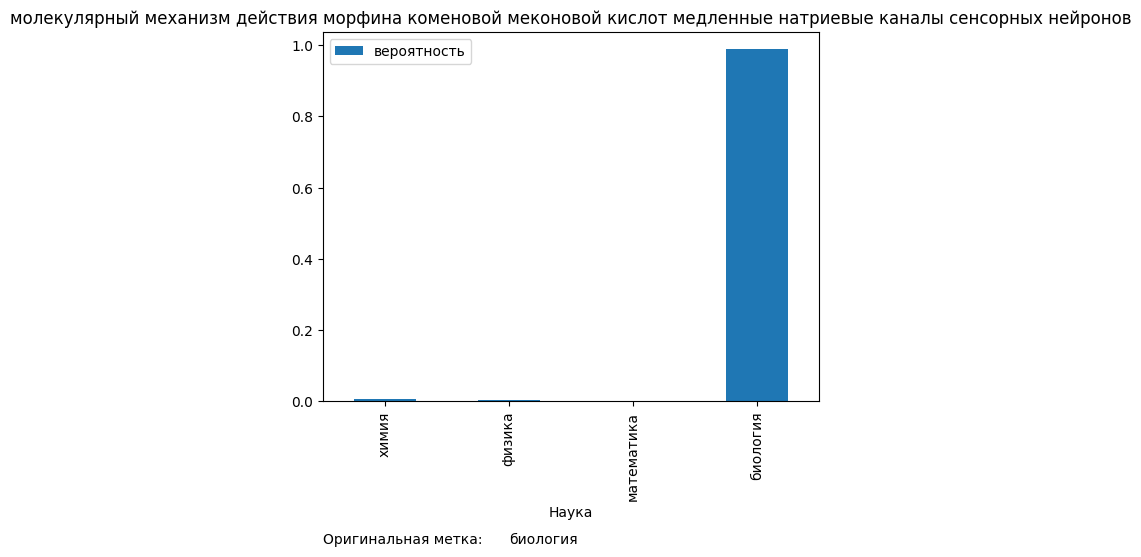

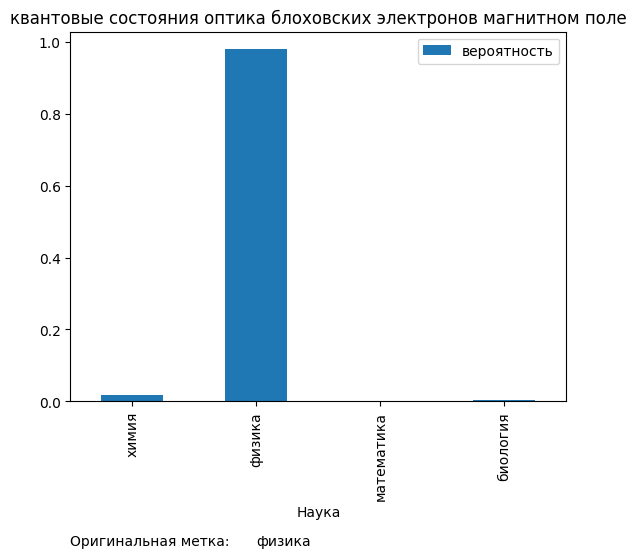

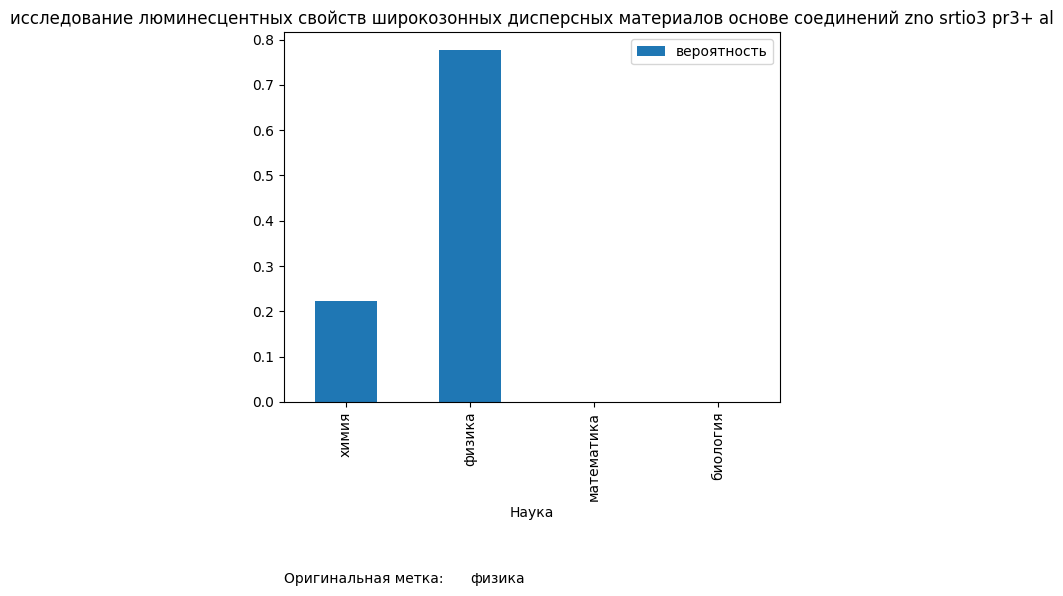

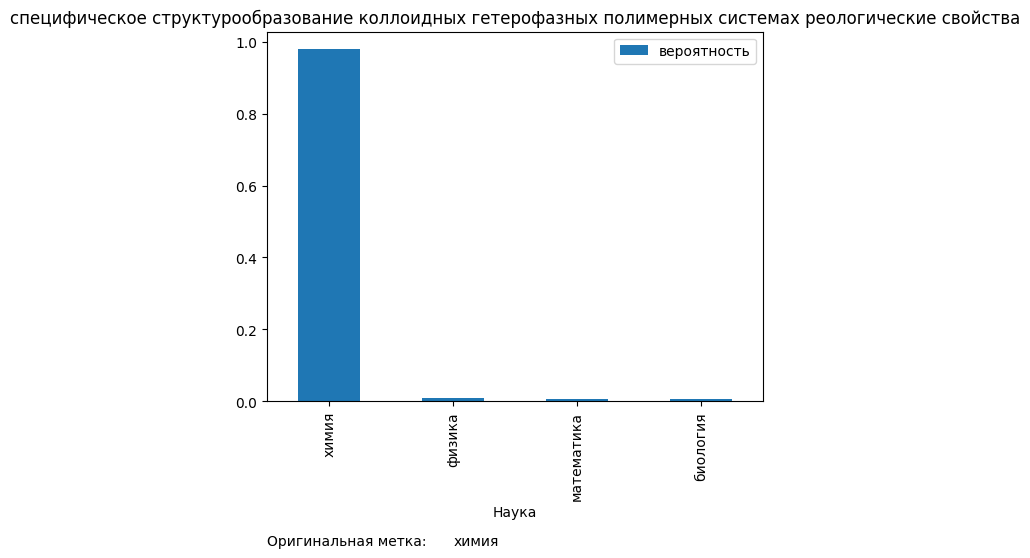

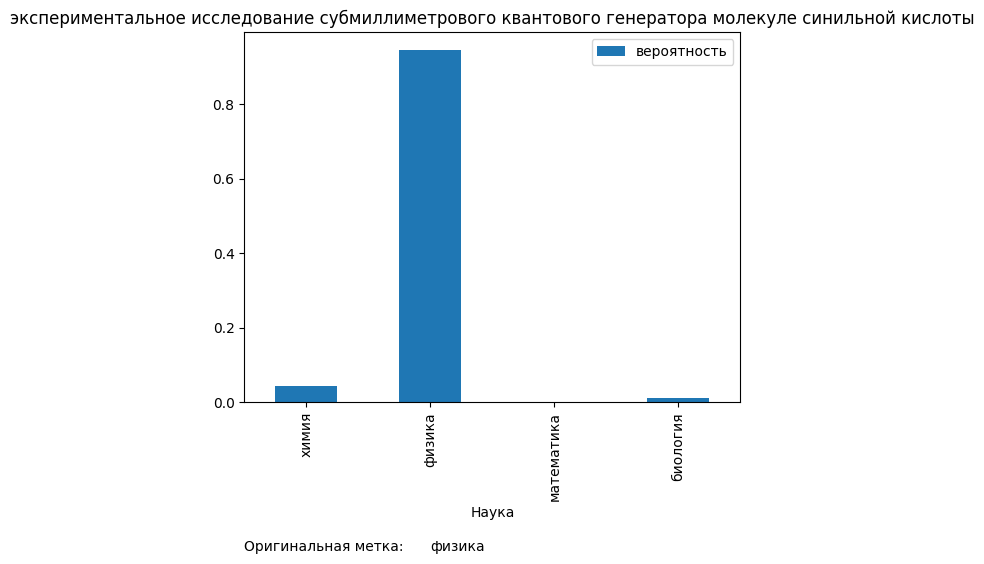

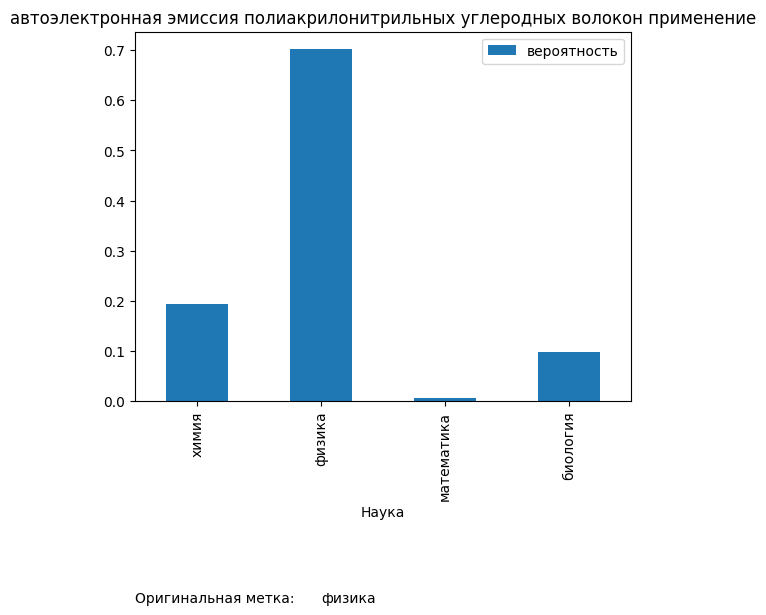

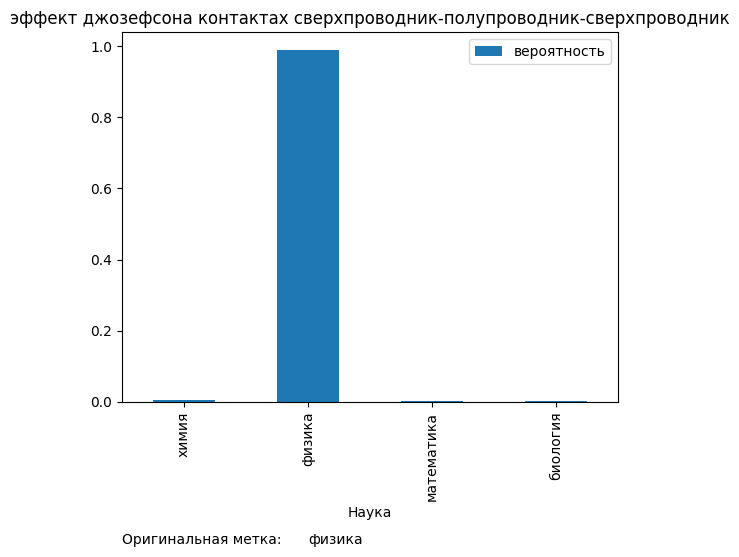

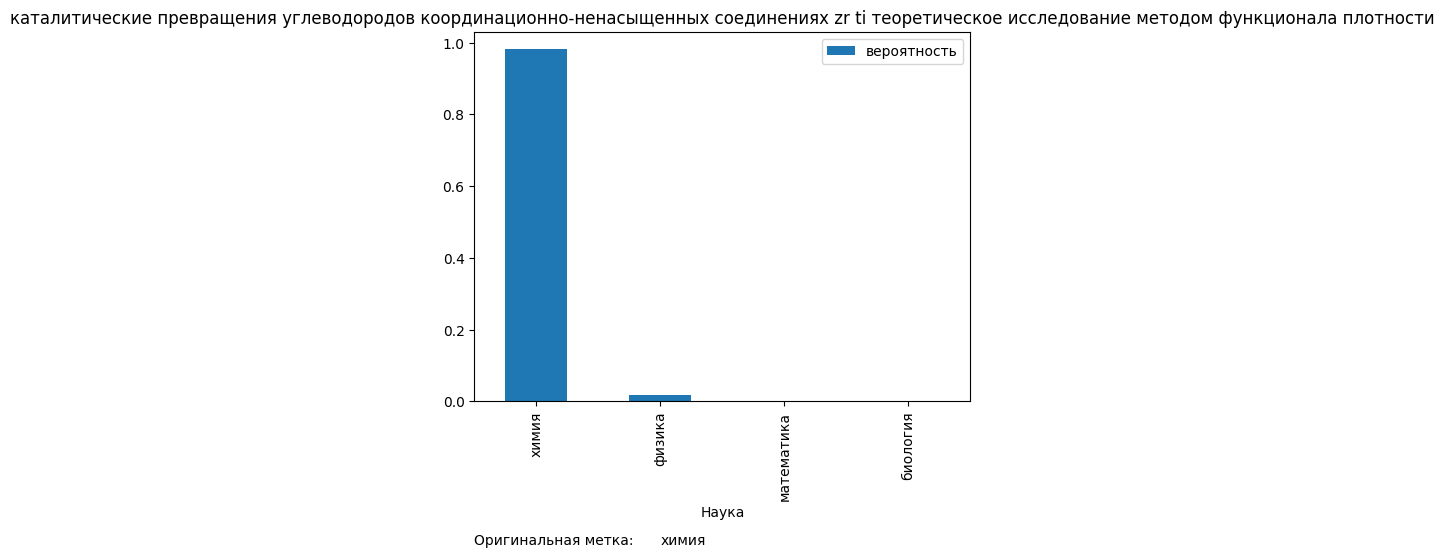

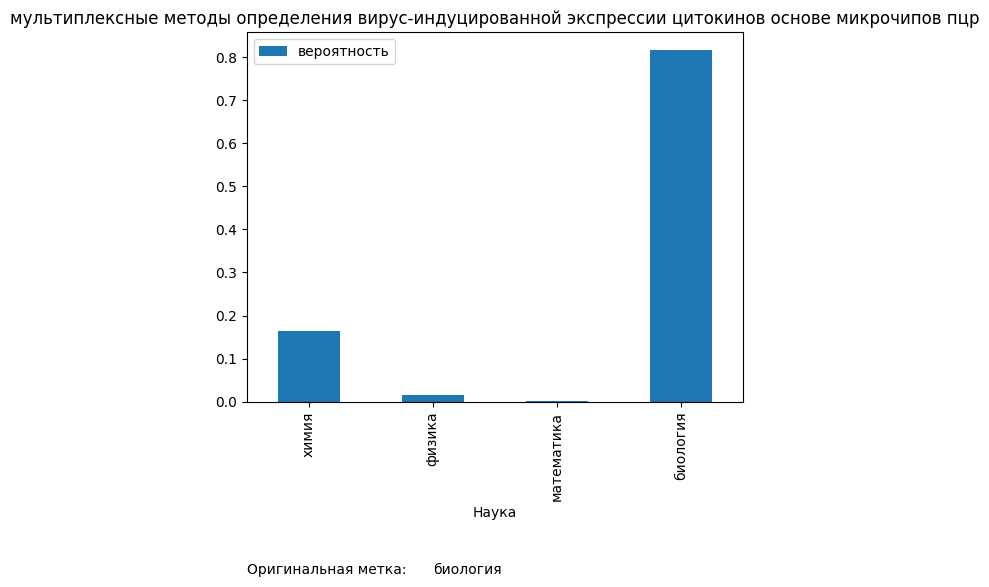

In [117]:
for i in range(20):
    y = random.randint(0, len(test))
    #print(test.iloc [y, test.columns.get_loc('test_text')])
    #print(test.iloc [y, test.columns.get_loc('test_label')])
    # creating dataframe 
    df = pd.DataFrame({ 
    'Наука': ['химия', 'физика', 'математика', 'биология'], 
    'вероятность': [test.iloc [y, test.columns.get_loc('химия')], test.iloc [y, test.columns.get_loc('физика')], test.iloc [y, test.columns.get_loc('математика')], test.iloc [y, test.columns.get_loc('биология')]] 
    }) 
    # plotting a bar graph 
    df.plot(x="Наука", y="вероятность", kind="bar", title= test.iloc [y, test.columns.get_loc('test_text_original')])
    plt.text(-0.5, -0.4, "Оригинальная метка:")
    plt.text(1, -0.4, test.iloc [y, test.columns.get_loc('test_label')] , fontsize=10 )
 #   pdf.savefig()
 #   plt.close()  
#pdf.close()
    

In [118]:
clf = LogisticRegression(penalty='l2',
    C=2, class_weight= 'balanced', solver='lbfgs',
    random_state=42
)
clf.fit(X_train_w2v, train_y)

LogisticRegression(C=2, class_weight='balanced', random_state=42)

In [119]:
#y_pred = clf.predict(X_test_w2v)
#print(f1_score(test_y, y_pred, average='weighted'))
#print(f1_score(test_y, y_pred, average='macro'))
#print(accuracy_score(test_y, y_pred))

In [120]:
!pip install scikit-optimize


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [121]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real

In [122]:
param_grid = [    
    {'C' : np.logspace(-10, 10, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000],
    'class_weight' : [None, 'balanced'],

    }
]

# Создание модели и настройка с использованием байесовской оптимизации
#logreg = LogisticRegression()
#bayes_search = BayesSearchCV(logreg, param_grid, n_iter=50, cv=5)
#bayes_search.fit(X_train_tf, train_y)

# Вывод наилучших гиперпараметров и оценки
#print("Best Hyperparameters:", bayes_search.best_params_)
#print("Best Cross-Validation Score:", bayes_search.best_score_)

In [123]:
%%time
# Определение пространства поиска гиперпараметров
param_space = {
    "loss":["hinge", "modified_huber", "log_loss", 'squared_epsilon_insensitive', 'perceptron', 'squared_hinge'],
    "n_jobs":[-1],
    "penalty":["l2", "l1", "elasticnet"],
    "max_iter":[500, 1000, 2500, 5000],
    'class_weight':[None, 'balanced']
 #   'learning_rate':['optimal', 'invscaling', 'adaptive']
}

# Создание модели и настройка с использованием байесовской оптимизации
#SGD = SGDClassifier()
#bayes_search_2 = BayesSearchCV(SGD, param_space, n_iter=50, cv=5)
#bayes_search_2.fit(X_train_cv, train_y)

#Вывод наилучших гиперпараметров и оценки
#print("Best Hyperparameters:", bayes_search_2.best_params_)
#print("Best Cross-Validation Score:", bayes_search_2.best_score_)

CPU times: total: 0 ns
Wall time: 0 ns
